# Kernel SVM

In [ ]:
#@title Import libraries {display-mode: "form"}

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title Helper functions {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

# Helper functions
def draw_grid(x_lim=np.array([-4, 4]), y_lim=np.array([-4, 4])):
    """Draw an empty grid"""
    ax = plt.gca()
    # Draw ticks and grid
    for i in range(int(x_lim.min()), int(x_lim.max())):
        ax.axvline(i, linestyle='--', color='#ecf0f1', zorder=0)
        ax.plot([i, i], [0.05, -0.05], color='#2c3e50')
    for i in range(int(y_lim.min()), int(y_lim.max())):
        ax.axhline(i, linestyle='--', color='#ecf0f1', zorder=0)
        ax.plot([0.05, -0.05], [i, i], color='#2c3e50')
    # x and y axis
    ax.axhline(0, color='#2c3e50', zorder=0)
    ax.axvline(0, color='#2c3e50', zorder=0)
    ax.scatter([0], [0], color='#c0392b', zorder=0)

    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

def draw_vectors(vectors, origin='origin', cmap=None, labels=None):
    if cmap:
        colors = cmap
    else:
        colors = ['#3498db', '#e67e22', '#f1c40f', '#2ecc71', '#1abc9c']

    if origin == 'origin':
        x_0 = np.zeros(len(vectors))
        y_0 = np.zeros(len(vectors))
    else:
        x_0, y_0 = origin[:, 0], origin[:, 1]
    ax = plt.gca()
    if labels:
        for i in range(len(vectors)):
            ax.text(vectors[i][0]+0.1, vectors[i][1]+0.2, labels[i],
                    {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
                    'bbox': dict(boxstyle="round", fc="white", alpha=0)})
    ax.quiver(x_0, y_0, vectors[:, 0], vectors[:, 1],
              angles='xy', scale_units='xy', scale=1, color=colors)

def projection(x, y, draw_vector=True):
    color = '#95a5a6'
    ax = plt.gca()
    dot_product = np.dot(x, y)
    y_norm = y / np.dot(y, y)
    x_projection = y_norm * dot_product
    ax.plot((x[0], x_projection[0]), (x[1], x_projection[1]), linestyle='--', linewidth=3, c=color)
    if draw_vector:
        draw_vectors(np.array([x_projection]), cmap=['#bdc3c7'])

def determinant_area(i_hat, j_hat):
    ax = plt.gca()
    sum_vector = i_hat + j_hat
    polygon = plt.Polygon([(0, 0), i_hat, sum_vector, j_hat], fill=True, color='#f39c12', alpha=0.3)
    print('Determinant Area:', np.abs(i_hat[0]*j_hat[1] - i_hat[1]*j_hat[0]))
    ax.add_line(polygon)
    
def projection_onto_H(x, w, b):
    ax = plt.gca()
    alpha = (np.dot(x, w) + b) / np.dot(w, w)
    d = alpha * w
    x_projection = x - d
    ax.plot((x[0], x_projection[0]), (x[1], x_projection[1]), linestyle='--', linewidth=3, c='#95a5a6')
    
def plot_margins(X, y, w, b):
    ax = plt.gca()
    gamma = np.abs(np.dot(X, w) + b) / np.sqrt(np.dot(w, w))
    x_pos = X[y==1][np.argmin(gamma[y == 1])]
    x_neg = X[y==0][np.argmin(gamma[y == 0])]
    d_pos = gamma[y==1][np.argmin(gamma[y == 1])]
    d_neg = gamma[y==0][np.argmin(gamma[y == 0])]
    
    ax.scatter([x_pos[0], x_neg[0]],[x_pos[1], x_neg[1]], s=150, linewidth=2, facecolor='none', edgecolors='#2c3e50')
    projection_onto_H(x_pos, w, b)
    projection_onto_H(x_neg, w, b)
    ax.set_title(f'Margin Class +1: {d_pos:.3f}, Class -1: {d_neg:.3f}', fontsize=24)
    
def plot_svc(model, plot_support=True):
    ax = plt.gca()
    xlim = ax.get_xlim() 
    ylim = ax.get_ylim() 
    
    # create grid (coordinate system - x and y) to evaluate model
    x = np.linspace(xlim[0], xlim[1], 40)
    y = np.linspace(ylim[0], ylim[1], 40) 
    X, Y = np.meshgrid(x, y)
    flatten_X = X.ravel() 
    flatten_Y = Y.ravel()
    xy = np.vstack([flatten_X, flatten_Y]).T 
    Z = model.decision_function(xy).reshape(X.shape)

    # Plot decision boundary and margins.
    ax.contour(X, Y, Z, colors='k', # draw filled contours
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    
    # plot circle around the support vectors returned by fitted SVC model
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], 
                   model.support_vectors_[:, 1],
                   s=150, linewidth=2, facecolors='none', edgecolors='k')
        
def plot_hyperplane(w, b):
    ax = plt.gca()
    draw_vectors(np.array([w]), origin=np.array([[(-b/w[0]), 0]]))
    x_1 = np.linspace(-8, 8, 100)
    ax.plot(x_1, (-w[0]/w[1])*x_1 + (-b/w[1]))

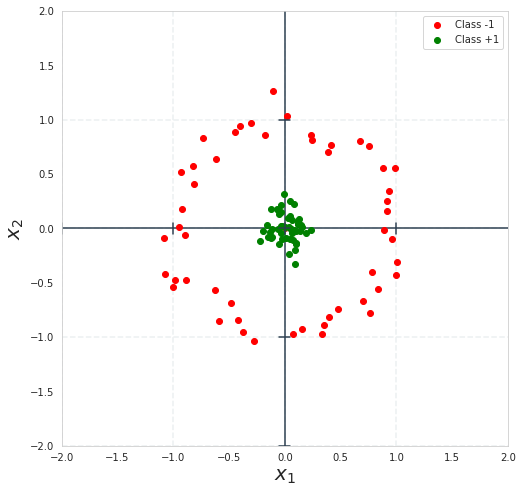

In [ ]:
#@title Non-linearly separable data {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

# Hyperplane example
from sklearn.datasets.samples_generator import make_circles, make_moons

X, y = make_circles(100, factor=.1, noise=.1)

plt.figure(figsize=(8, 8))
draw_grid(x_lim=np.array([-2, 2]), y_lim=np.array([-2, 2]))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='g', label='Class +1')

plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20)
plt.legend()
plt.show()

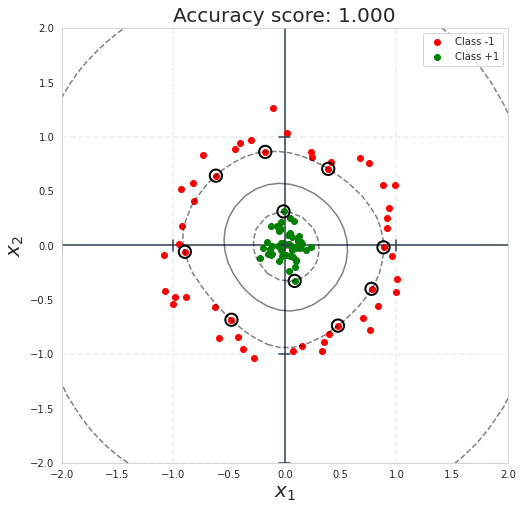

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='rbf', C=1e6)
clf.fit(X, y)

plt.figure(figsize=(8, 8))
draw_grid(x_lim=np.array([-2, 2]), y_lim=np.array([-2, 2]))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='g', label='Class +1')

plot_svc(clf)
# only with linear kernel
# plot_hyperplane(clf.coef_[0], clf.intercept_[0])

plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20)
plt.title(f'Accuracy score: {accuracy_score(y, clf.predict(X)):.3f}', fontsize=20)
plt.legend()
plt.show()


## Kernel method

The main idea of [kernel methods](https://en.wikipedia.org/wiki/Kernel_method) is projecting the data into a high dimensional space where it is linearly separable and find a hyperplane in this space.

In [ ]:
#@title Linearly separable data in higher dimensional space {display-mode: "form"}

from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

r = np.exp(-(X ** 2).sum(axis = 1))
def plot_3D(elev=90, azim=90, X=X, y=y):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, linewidth=1, edgecolor='k')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(0, 90), azim=(0, 90),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=90, description='elev', max=90), IntSlider(value=90, description='azim',…

In [ ]:
#@title Demo {display-mode: "form"}

%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/3liCbRZPrZA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The projecting data into high dimensional space is actually a feature transfomation on the input feature vector $\mathbf{x} \in R^n $.

Formally, for a data vector $\mathbf{x} \in R^n $, we apply the transformation $\mathbf{x} \rightarrow \phi(\mathbf{x})$ where $\phi(\mathbf{x})\in\mathbb{R}^N$ with $N \gg n$.

Note that you still can use gradient descent code, just with the higher dimensional representation (replace $n$ with $N$).

The problem would be that $\phi(\mathbf{x})$ might be very high dimensional.

Consider the following example: Let's say we add features of any possible interaction between any of the input features. 

$$
\mathbf{x}=\begin{pmatrix}x_1\\ x_2\\ \vdots \\ x_n \end{pmatrix} \text{, and } \phi(\mathbf{x})=\begin{pmatrix}1\\ x_1\\ \vdots \\x_n \\ x_1x_2 \\ \vdots \\ x_{1}x_n\\ x_2x_3 \\ \vdots \\ x_{n-1}x_n\\ \vdots \\x_1x_2\cdots x_n \end{pmatrix}
$$

**Quiz: What is the dimensionality of $\phi(\mathbf{x})$?**

In [ ]:
# 2**n = #dimensions of phi
(4 * 2**64) / 1024/ 1024 / 1024

68719476736.0

### The kernel trick

Starting from the hard margin optimization problem, our objective is:

$$
\begin{align}
&\min_{\mathbf{w},b}\mathbf{w}^T\mathbf{w}&\\ 
&\textrm{s.t.} \ \ \ \forall i \ y^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)}+b) \geq 1 &
\end{align}
$$

We know that the hyperplane is defined by the support vectors, so for all $\mathbf{x}^{(i)}$ is support vectors, our objective becomes:

$$
\begin{align}
&\min_{\mathbf{w},b}\mathbf{w}^T\mathbf{w}&\\ 
&\textrm{s.t.} \ \ \  \ y^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)}+b) = 1 &
\end{align}
$$

**The Lagrange multiplier**

From here we can apply the [Lagrange multiplier](https://en.wikipedia.org/wiki/Lagrange_multiplier), which is a method for finding the extremum of a function with contraints. Consider the optimization problem:

*maximize* $f(x,y)$

*subject to*: $g(x, y) = 0$


<img src="https://cdn.kastatic.org/ka-perseus-images/98a7772076e49fa60eef3b3062a540ddc7130ad5.png" width="50%" />


<img src="https://upload.wikimedia.org/wikipedia/commons/f/fa/Lagrange_multiplier.png" width="30%" />

The red curve shows the constraint $g(x, y) = c$. The blue curves are contours of $f(x, y)$. The point where the red constraint tangentially touches a blue contour is the maximum of $f(x, y)$ along the constraint.

We introduce a new variable $\lambda$ called a **Lagrange multiplier** and study the **Lagrange function** (or **Lagrangian** or **Lagrangian expression**) defined by:

$$
\mathcal{L}(x, y, \lambda) = f(x, y) - \lambda g(x, y)
$$

This gives us a new expression, which we can maximize or minimize **without thinking about the contraints anymore**.




Apply the Lagrange multiplier to our optimization problem, we have the Lagrangian expression:

$$
\mathcal{L} = \frac{1}{2} \mathbf{w}^T\mathbf{w} - \sum{\lambda^{(i)} \big( y^{(i)}( \mathbf{w}^T \mathbf{x}^{(i)}+b) - 1 \big)}
$$

Then

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \mathbf{w} - \sum{\lambda^{(i)}y^{(i)}\mathbf{x}^{(i)}} = 0
\Rightarrow \mathbf{w} = \sum{\lambda^{(i)}y^{(i)}\mathbf{x}^{(i)}}
$$

$$
\frac{\partial \mathcal{L}}{\partial b} = \sum{\lambda^{(i)}y^{(i)}} = 0
$$

Our expression becomes:

$$\begin{align}
\mathcal{L} &= \frac{1}{2} \big( \sum{\lambda^{(i)}y^{(i)}\mathbf{x}^{(i)}} \big) \cdot \big( \sum{\lambda^{(i)}y^{(i)}\mathbf{x}^{(i)}} \big) - \big( \sum{\lambda^{(i)}y^{(i)}\mathbf{x}^{(i)}} \big) \cdot \big( \sum{\lambda^{(i)}y^{(i)}\mathbf{x}^{(i)}} \big) - \big( b \sum{\lambda^{(i)}y^{(i)}} \big) + \sum\lambda^{(i)} \\
&= \sum\lambda^{(i)} - \frac{1}{2} \big( \sum_{i}\sum_{j}{\lambda^{(i)}\lambda^{(j)}y^{(i)}y^{(j)}\mathbf{x}^{(i)}\mathbf{x}^{(j)}} \big) 
\end{align}$$

We can see that **the optimization problem depends only on the dot product of pairs of samples** $\mathbf{x}^{(i)}\mathbf{x}^{(j)}$.

In the testing-time, when we make prediction on a unknown vector $\mathbf{u}$, the classifier also depends on the dot products between the test point and training points:

$$
\sum{\lambda^{(i)}y^{(i)}\mathbf{x}^{(i)}}\mathbf{u} + b \geq 0 \Rightarrow \text{classify as +1, otherwise -1}
$$

So the only information we need in order to learn a hyperplane classifier is dot products between all pairs of data vectors.


**The kernel trick**

Go back to our feature transformation to solve non-linearity problem, we have the training process in the high dimensional space of $\phi(\mathbf{x})$ also depends on the dot product $\phi(\mathbf{x}^{(i)})^\top\phi(\mathbf{x}^{(j)})$. We define a function called the kernel function:

$$
\begin{equation}
k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})=\phi(\mathbf{x}^{(i)})^\top \phi(\mathbf{x}^{(j)}).
\end{equation}
$$

Now let's take a look at the dot product $\phi(\mathbf{x})^\top \phi(\mathbf{z})$ between two vectors $\mathbf{x}, \mathbf{z}$. We can prove that:

$$
\begin{equation}
  \phi(\mathbf{x})^\top \phi(\mathbf{z})=1\cdot 1+x_1z_1+x_2z_2+\cdots +x_1x_2z_1z_2+ \cdots +x_1\cdots x_dz_1\cdots z_d=\prod_{i=1}^n(1+x_iz_i)
\end{equation}
$$

This is called the **kernel trick**. We don't have to explicitly calculate the dot product $\phi(\mathbf{x}^{(i)})^\top\phi(\mathbf{x}^{(j)})$, or even any $\phi(\mathbf{x})$.

This trick allows us to map our data to an exponentially high dimensional space, and we run our algorithm in this high dimensional space. But we never once compute a single instance in that high dimensional space, because we only need the dot products which we can compute those very efficiently using the kernel function. This idea is exceedingly powerful.



## Popular Kernel functions


* **Linear**: $\mathsf{K}(\mathbf{x},\mathbf{z})=\mathbf{x}^\top \mathbf{z}$, `kernel='linear'` in `sklearn.svm.SVC`

* **Polynomial:** $\mathsf{K}(\mathbf{x},\mathbf{z})=(\text{coef0} + \gamma\mathbf{x}^\top \mathbf{z})^{degree}$, `kernel='poly'` in `sklearn.svm.SVC`

* **Radial Basis Function (RBF or Gaussian Kernel):** $\mathsf{K}(\mathbf{x},\mathbf{z})= e^{-\gamma\|\mathbf{x}-\mathbf{z}\|^2}$, `kernel='rbf'` in `sklearn.svm.SVC` (**default**)

* **Sigmoid Kernel:** $\mathsf{K}(\mathbf{x},\mathbf{z})=\tanh(\gamma\mathbf{x}^\top\mathbf{z}  + \text{coef0})$, `kernel='sigmoid'` in `sklearn.svm.SVC`

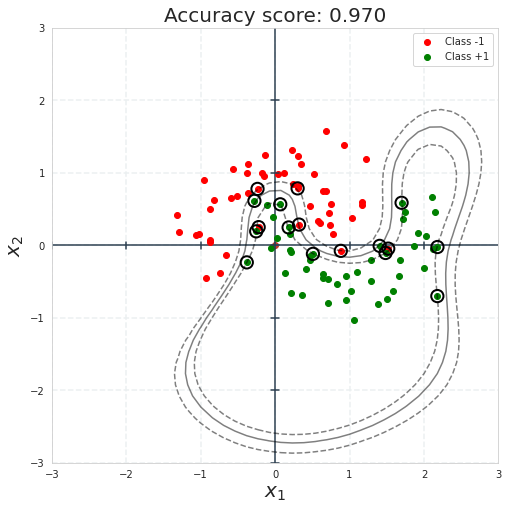

In [ ]:
# Find a good kernel function to classify this dataset
X, y = make_moons(noise=0.3, random_state=0)

# Your code starts here
clf = SVC(kernel='rbf', C=1e3, gamma=0.5)
clf.fit(X, y)
# Your code ends

plt.figure(figsize=(8, 8))
draw_grid(x_lim=np.array([-3, 3]), y_lim=np.array([-3, 3]))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='g', label='Class +1')

plot_svc(clf)

plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20)
plt.title(f'Accuracy score: {accuracy_score(y, clf.predict(X)):.3f}', fontsize=20)
plt.legend()
plt.show()